
<a id='opt-tax-recur'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Optimal Taxation with State-Contingent Debt

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [Optimal Taxation with State-Contingent Debt](#Optimal-Taxation-with-State-Contingent-Debt)  
  - [Overview](#Overview)  
  - [A Competitive Equilibrium with Distorting Taxes](#A-Competitive-Equilibrium-with-Distorting-Taxes)  
  - [Recursive Formulation of the Ramsey problem](#Recursive-Formulation-of-the-Ramsey-problem)  
  - [Examples](#Examples)  
  - [Further Comments](#Further-Comments)  

## Overview

This lecture describes a celebrated model of optimal fiscal policy by Robert E.
Lucas, Jr., and Nancy Stokey  [[LS83]](../zreferences.html#lucasstokey1983).

The model revisits classic issues about how to pay for a war.

Here a *war* means a more  or less temporary surge in an exogenous government expenditure process.

The model features

- a government that must finance an exogenous stream of government expenditures with  either  
  
  - a flat rate tax on labor, or  
  - purchases and sales from a full array of Arrow state-contingent securities  
  
- a representative household that values consumption and leisure  
- a linear production function mapping labor into a single good  
- a Ramsey planner who at time $ t=0 $ chooses a plan for taxes and
  trades of [Arrow securities](https://en.wikipedia.org/wiki/Arrow_security) for all $ t \geq 0 $  


After first presenting the model in a space of sequences, we shall represent it
recursively in terms of two Bellman equations formulated along lines that we
encountered in [Dynamic Stackelberg models](dyn_stack.html).

As in [Dynamic Stackelberg models](dyn_stack.html), to apply dynamic programming
we shall define the state vector artfully.

In particular, we shall include forward-looking variables that summarize  optimal
responses of private agents to a Ramsey plan.

See [Optimal taxation](lqramsey.html) for an analysis within a linear-quadratic setting.

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

In [2]:
using LinearAlgebra, Statistics
using QuantEcon, NLsolve, NLopt, Interpolations

## A Competitive Equilibrium with Distorting Taxes

For $ t \geq 0 $, a history $ s^t = [s_t, s_{t-1}, \ldots, s_0] $ of an
exogenous state $ s_t $ has joint probability density $ \pi_t(s^t) $.

We begin by assuming that government purchases $ g_t(s^t) $ at time $ t \geq 0 $ depend on $ s^t $.

Let $ c_t(s^t) $,  $ \ell_t(s^t) $, and $ n_t(s^t) $ denote consumption,
leisure, and labor supply, respectively, at history $ s^t $ and date $ t $.

A representative  household is endowed with one unit of time that can be divided
between leisure $ \ell_t $ and labor $ n_t $:


<a id='equation-feas1-opt-tax'></a>
$$
n_t(s^t) + \ell_t(s^t) = 1 \tag{1}
$$

Output equals $ n_t(s^t) $ and can be divided between $ c_t(s^t) $ and $ g_t(s^t) $


<a id='equation-tss-techr-opt-tax'></a>
$$
c_t(s^t) + g_t(s^t) = n_t(s^t) \tag{2}
$$

A representative household’s preferences over $ \{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty $ are ordered by


<a id='equation-ts-prefr-opt-tax'></a>
$$
\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), \ell_t(s^t)] \tag{3}
$$

where the utility function $ u $ is  increasing, strictly concave, and three
times continuously differentiable in both arguments.

The technology pins down a pre-tax wage rate to unity for all $ t, s^t $.

The government imposes a flat-rate tax $ \tau_t(s^t) $ on labor income at
time $ t $, history $ s^t $.

There are complete markets in one-period Arrow securities.

One unit of an Arrow security  issued at time $ t $ at history $ s^t $
and promising to pay one unit of time $ t+1 $ consumption in state $ s_{t+1} $
costs $ p_{t+1}(s_{t+1}|s^t) $.

The government issues one-period Arrow securities each period.

The government has a sequence of budget constraints whose time $ t \geq 0 $ component is


<a id='equation-ts-govr'></a>
$$
g_t(s^t) =   \tau_t(s^t)  n_t(s^t) + \sum_{s_{t+1}} p_{t+1}(s_{t+1} | s^t) b_{t+1}(s_{t+1} | s^t) -
b_t(s_t | s^{t-1}) \tag{4}
$$

where

- $ p_{t+1}(s_{t+1}|s^t) $ is a competitive equilibrium price of one unit of
  consumption at date $ t+1 $ in state $ s_{t+1} $ at date $ t $ and history $ s^t $  
- $ b_t(s_t|s^{t-1}) $ is government debt falling due at time $ t $, history $ s^t $.  


Government debt $ b_0(s_0) $ is an exogenous initial condition.

The representative household has a sequence of budget constraints whose time $ t\geq 0 $ component is


<a id='equation-ts-bcr'></a>
$$
c_t(s^t) + \sum_{s_{t+1}} p_t(s_{t+1} | s^t) b_{t+1}(s_{t+1} | s^t)
=  \left[1-\tau_t(s^t)\right]  n_t(s^t) + b_t(s_t | s^{t-1}) \quad \forall t \geq 0. \tag{5}
$$

A  **government policy** is an exogenous sequence $ \{g(s_t)\}_{t=0}^\infty $,
a tax rate sequence $ \{\tau_t(s^t)\}_{t=0}^\infty $, and a government debt sequence $ \{b_{t+1}(s^{t+1})\}_{t=0}^\infty $.

A **feasible allocation** is a consumption-labor supply plan $ \{c_t(s^t), n_t(s^t)\}_{t=0}^\infty $
that satisfies [(2)](#equation-tss-techr-opt-tax) at all $ t, s^t $.

A **price system** is a sequence of Arrow security prices $ \{p_{t+1}(s_{t+1} | s^t) \}_{t=0}^\infty $.

The household faces the price system as a price-taker and takes the government policy as given.

The household chooses $ \{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty $ to maximize [(3)](#equation-ts-prefr-opt-tax) subject to [(5)](#equation-ts-bcr) and [(1)](#equation-feas1-opt-tax) for all $ t, s^t $.

A **competitive equilibrium with distorting taxes** is a feasible allocation,
a price system, and a government policy such that

- Given the price system and the government policy, the allocation solves the
  household’s optimization problem.  
- Given the allocation, government policy, and  price system, the government’s
  budget constraint is satisfied for all $ t, s^t $.  


Note: There are many competitive equilibria with distorting taxes.

They are indexed by different government policies.

The **Ramsey problem** or **optimal taxation problem** is to choose a competitive
equilibrium with distorting taxes that maximizes [(3)](#equation-ts-prefr-opt-tax).

### Arrow-Debreu Version of Price System

We find it convenient sometimes to work with the Arrow-Debreu price system that is
implied by a sequence of Arrow securities prices.

Let $ q_t^0(s^t) $ be the price at time $ 0 $, measured in time $ 0 $
consumption goods, of one unit of consumption at time $ t $,
history $ s^t $.

The following recursion relates Arrow-Debreu prices $ \{q_t^0(s^t)\}_{t=0}^\infty $
to Arrow securities prices $ \{p_{t+1}(s_{t+1}|s^t)\}_{t=0}^\infty $


<a id='equation-ts-foc'></a>
$$
q^0_{t+1}(s^{t+1}) = p_{t+1}(s_{t+1}|s^t) q^0_t(s^t) \quad s.t. \quad q_0^0(s^0) = 1 \tag{6}
$$

Arrow-Debreu prices are useful when we want to compress a sequence of budget
constraints into a single intertemporal budget constraint, as we shall find it
convenient to do below.

### Primal Approach

We apply a popular approach to solving a Ramsey problem, called the *primal approach*.

The idea is to use first-order conditions for household optimization to
eliminate taxes and prices in favor of quantities, then pose an optimization problem
cast entirely in terms of quantities.

After Ramsey quantities have been found, taxes and prices can then be unwound
from the allocation.

The primal approach uses four steps:

> 1. Obtain  first-order conditions of the household’s problem and solve them for $ \{q^0_t(s^t), \tau_t(s^t)\}_{t=0}^\infty $ as functions of
the allocation $ \{c_t(s^t), n_t(s^t)\}_{t=0}^\infty $.

2. Substitute these expressions for taxes and prices in terms of the allocation
into the household’s present-value budget constraint.

> - This intertemporal constraint involves only the allocation and is regarded
  as an *implementability constraint*.  



3. Find the allocation that maximizes the utility of the representative household
[(3)](#equation-ts-prefr-opt-tax) subject to  the feasibility constraints [(1)](#equation-feas1-opt-tax)
and [(2)](#equation-tss-techr-opt-tax)  and the implementability condition derived in step 2.

> - This optimal allocation is called the **Ramsey allocation**.  



4. Use the Ramsey  allocation together with the formulas from step 1 to find
taxes and prices.

### The Implementability Constraint

By sequential substitution of one one-period budget constraint [(5)](#equation-ts-bcr) into
another, we can obtain the household’s present-value budget constraint:


<a id='equation-ts-bcpv2'></a>
$$
\sum_{t=0}^\infty \sum_{s^t} q^0_t(s^t) c_t(s^t) =
\sum_{t=0}^\infty \sum_{s^t} q^0_t(s^t) [1-\tau_t(s^t)] n_t(s^t) +
b_0 \tag{7}
$$

$ \{q^0_t(s^t)\}_{t=1}^\infty $ can be interpreted as a time $ 0 $
Arrow-Debreu price system.

To approach the Ramsey problem, we study the household’s optimization problem.

First-order conditions for the household’s problem for $ \ell_t(s^t) $
and $ b_t(s_{t+1}| s^t) $, respectively, imply


<a id='equation-lsa-taxr'></a>
$$
(1 - \tau_t(s^t)) = {\frac{u_l(s^t)}{u_c(s^t)}} \tag{8}
$$

and


<a id='equation-ls101'></a>
$$
p_{t+1}(s_{t+1}| s^t) = \beta \pi(s_{t+1} | s^t) \left({\frac{u_c(s^{t+1})}{u_c({s^t})}} \right) \tag{9}
$$

where $ \pi(s_{t+1} | s^t) $ is the probability distribution of $ s_{t+1} $
conditional on history $ s^t $.

Equation [(9)](#equation-ls101) implies that the Arrow-Debreu price system satisfies


<a id='equation-ls102'></a>
$$
q_t^0(s^t) = \beta^{t} \pi_{t}(s^{t})
                            {u_c(s^{t})  \over u_c(s^0)} \tag{10}
$$

Using the first-order conditions [(8)](#equation-lsa-taxr) and [(9)](#equation-ls101) to eliminate
taxes and prices from [(7)](#equation-ts-bcpv2), we derive the *implementability condition*


<a id='equation-tss-cham1'></a>
$$
\sum_{t=0}^\infty  \sum_{s^t} \beta^t \pi_t(s^t)
         [u_c(s^t) c_t(s^t) - u_\ell(s^t) n_t(s^t)] -
         u_c(s^0) b_0 = 0. \tag{11}
$$

The **Ramsey problem** is to choose a feasible  allocation  that maximizes


<a id='equation-ts-prefr2'></a>
$$
\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), 1 - n_t(s^t)] \tag{12}
$$

subject to  [(11)](#equation-tss-cham1).

### Solution Details

First define a “pseudo utility function”


<a id='equation-ts-cham17'></a>
$$
V\left[c_t(s^t), n_t(s^t), \Phi\right] =
u[c_t(s^t),1-n_t(s^t)] +
\Phi \left[ u_c(s^t) c_t(s^t) -
u_\ell(s^t) n_t(s^t) \right] \tag{13}
$$

where $ \Phi $ is a Lagrange multiplier on the implementability condition [(7)](#equation-ts-bcpv2).

Next form the Lagrangian


<a id='equation-ts-chamlag'></a>
$$
J  = \sum_{t=0}^\infty
\sum_{s^t} \beta^t \pi_t(s^t)
\Bigl\{
    V[c_t(s^t), n_t(s^t), \Phi]   + \theta_t(s^t)
   \Bigl[ n_t(s^t) - c_t(s^t) - g_t(s_t) \Bigr]
\Bigr\} - \Phi u_c(0) b_0 \tag{14}
$$

where  $ \{\theta_t(s^t); \forall s^t\}_{t\geq0} $ is a sequence of Lagrange
multipliers on the feasible conditions [(2)](#equation-tss-techr-opt-tax).

Given an initial government debt $ b_0 $,  we want to maximize $ J $
with respect to $ \{c_t(s^t), n_t(s^t); \forall s^t \}_{t\geq0} $   and to minimize with respect
to $ \{\theta(s^t); \forall s^t \}_{t\geq0} $.

The first-order conditions for the Ramsey problem for periods $ t \geq 1 $ and $ t=0 $, respectively, are


<a id='equation-eqfoncramsey1'></a>
$$
\begin{aligned}
    c_t(s^t)\rm{:} &
    \; (1+\Phi) u_c(s^t) + \Phi \left[u_{cc}(s^t) c_t(s^t) -
    u_{\ell c}(s^t) n_t(s^t) \right]  - \theta_t(s^t) = 0, \quad t \geq 1
    \\
    n_t(s^t)\rm{:} &
    \; -(1+\Phi) u_{\ell}(s^t) - \Phi \left[u_{c\ell}(s^t) c_t(s^t) -
    u_{\ell \ell}(s^t) n_t(s^t) \right] + \theta_t(s^t) = 0, \quad t \geq 1
\end{aligned} \tag{15}
$$

and


<a id='equation-eqfoncramsey0'></a>
$$
\begin{aligned}
    c_0(s^0, b_0)\rm{:} &
    \; (1+\Phi) u_c(s^0, b_0) + \Phi \left[u_{cc}(s^0, b_0) c_0(s^0, b_0) -
    u_{\ell c}(s^0, b_0) n_0(s^0, b_0) \right]  - \theta_0(s^0, b_0)   \\
       & \quad \quad \quad \quad \quad \quad  - \Phi u_{cc}(s^0, b_0) b_0 = 0
    \\
    n_0(s^0, b_0)\rm{:} &
    \; -(1+\Phi) u_{\ell}(s^0, b_0) - \Phi \left[u_{c\ell}(s^0, b_0) c_0(s^0, b_0) -
    u_{\ell \ell}(s^0, b_0) n_0(s^0, b_0) \right] + \theta_0(s^0, b_0) \\
      & \quad \quad \quad \quad \quad \quad + \Phi u_{c \ell}(s^0, b_0) b_0 = 0
\end{aligned} \tag{16}
$$

Please note how these first-order conditions differ between $ t=0 $ and $ t \geq 1 $.

It is instructive to use first-order conditions [(15)](#equation-eqfoncramsey1) for
$ t \geq 1 $ to eliminate the multipliers $ \theta_t(s^t) $.

For convenience, we suppress the time subscript and the index $ s^t $ and obtain


<a id='equation-ts-barg'></a>
$$
\begin{aligned}
  (1+\Phi) &u_c(c,1-c-g) + \Phi \bigl[c u_{cc}(c,1-c-g) -
  (c+g) u_{\ell c}(c,1-c-g) \bigr]
    \\
    &= (1+\Phi) u_{\ell}(c,1-c-g) + \Phi \bigl[c u_{c\ell}(c,1-c-g) -
    (c+g) u_{\ell \ell}(c,1-c-g)  \bigr]
\end{aligned} \tag{17}
$$

where we have imposed conditions [(1)](#equation-feas1-opt-tax) and [(2)](#equation-tss-techr-opt-tax).

Equation [(17)](#equation-ts-barg) is one equation that can be solved to express the
unknown $ c $ as a function of the  exogenous variable $ g $.

We also know that  time $ t=0 $ quantities $ c_0 $ and $ n_0 $ satisfy


<a id='equation-ts-barg-aust'></a>
$$
\begin{aligned}
      (1+\Phi) &u_c(c,1-c-g) + \Phi \bigl[c u_{cc}(c,1-c-g) -
      (c+g) u_{\ell c}(c,1-c-g) \bigr]
        \\
        &= (1+\Phi) u_{\ell}(c,1-c-g) + \Phi \bigl[c u_{c\ell}(c,1-c-g) -
        (c+g) u_{\ell \ell}(c,1-c-g)  \bigr] + \Phi (u_{cc} - u_{c,\ell}) b_0
\end{aligned} \tag{18}
$$

Notice that a counterpart to $ b_0 $ does *not* appear
in [(17)](#equation-ts-barg), so $ c $ does not depend on it for $ t \geq 1 $.

But things are different for time $ t=0 $.

An analogous argument for the $ t=0 $ equations [(16)](#equation-eqfoncramsey0) leads
to one equation that can be solved for $ c_0 $ as a function of the
pair $ (g(s_0), b_0) $.

These outcomes mean that the following statement would be  true even when
government purchases are history-dependent functions $ g_t(s^t) $ of the
history of $ s^t $.

**Proposition:**
If government purchases are equal after two histories
$ s^t $ and $ \tilde s^\tau $ for $ t,\tau\geq0 $, i.e., if

$$
g_t(s^t) = g^\tau(\tilde s^\tau) = g
$$

then it follows from [(17)](#equation-ts-barg) that the Ramsey  choices of consumption and leisure,
$ (c_t(s^t),\ell_t(s^t)) $ and $ (c_j(\tilde s^\tau),\ell_j(\tilde
s^\tau)) $, are identical.

The proposition asserts that the optimal allocation is a function of the
currently realized quantity of government purchases $ g $ only and does
*not* depend on the specific history that preceded that realization of $ g $.

### The Ramsey Allocation for a Given $ \Phi $

Temporarily take  $ \Phi $ as given.

We shall compute $ c_0(s^0, b_0) $ and $ n_0(s^0, b_0) $ from the first-order
conditions [(16)](#equation-eqfoncramsey0).

Evidently, for $ t \geq 1 $, $ c $ and
$ n $ depend on the time $ t $ realization of $ g $ only.

But for $ t=0 $, $ c $ and $ n $  depend on both $ g_0 $ and the
government’s initial debt $ b_0 $.

Thus, while $ b_0 $
influences $ c_0 $ and $ n_0 $, there appears no analogous
variable $ b_t $ that influences $ c_t $ and $ n_t $ for
$ t \geq 1 $.

The absence of $ b_t $ as a determinant of the  Ramsey allocation for
$ t \geq 1 $ and its presence for $ t=0 $ is a symptom of the
*time-inconsistency* of a Ramsey plan.

$ \Phi $ has to take a value that assures that
the household and the government’s budget constraints are both
satisfied at a candidate Ramsey allocation and price system associated
with that $ \Phi $.

### Further Specialization

At this point, it is useful to specialize the model in the following ways.

We assume that $ s $ is governed by a finite state Markov chain with states
$ s\in [1, \ldots, S] $ and transition matrix $ \Pi $, where

$$
\Pi(s'|s) = {\rm Prob}(s_{t+1} = s'| s_t =s)
$$

Also, assume that government purchases $ g $ are an exact time-invariant function
$ g(s) $ of $ s $.

We maintain these assumptions throughout the remainder of this lecture.

### Determining $ \Phi $

We complete the Ramsey plan by computing the Lagrange multiplier $ \Phi $
on the implementability constraint [(11)](#equation-tss-cham1).

Government budget balance restricts $ \Phi $ via the following line of reasoning.

The household’s first-order conditions imply


<a id='equation-lsa-ta'></a>
$$
(1 - \tau_t(s^t)) = {\frac{u_l(s^t)}{u_c(s^t)} } \tag{19}
$$

and the  implied one-period Arrow securities prices


<a id='equation-lsa-arro'></a>
$$
p_{t+1}(s_{t+1}| s^t) = \beta \Pi(s_{t+1} | s_t) {\frac{u_c(s^{t+1})}{u_c({s^t})}} \tag{20}
$$

Substituting from  [(19)](#equation-lsa-ta), [(20)](#equation-lsa-arro), and the feasibility
condition [(2)](#equation-tss-techr-opt-tax)  into the recursive version [(5)](#equation-ts-bcr) of
the household budget constraint gives


<a id='equation-lsa-budget'></a>
$$
\begin{aligned}
    u_c(s^t) [ n_t(s^t) - g_t(s^t)] +
    \beta \sum_{s_{t+1}} \Pi (s_{t+1}| s_t) u_c(s^{t+1}) b_{t+1}(s_{t+1} | s^t) = \\
    u_l (s^t) n_t(s^t) + u_c(s^t) b_t(s_t | s^{t-1})
\end{aligned} \tag{21}
$$

Define $ x_t(s^t) = u_c(s^t) b_t(s_t | s^{t-1}) $.

Notice that $ x_t(s^t) $ appears on the right side of [(21)](#equation-lsa-budget) while
$ \beta $ times the conditional expectation of
$ x_{t+1}(s^{t+1}) $ appears on the left side.

Hence the equation shares much of the structure of a simple asset pricing equation with
$ x_t $ being analogous to the price of the asset at time $ t $.

We learned earlier that for a Ramsey allocation
$ c_t(s^t), n_t(s^t) $ and $ b_t(s_t|s^{t-1}) $, and therefore
also $ x_t(s^t) $, are each functions of $ s_t $ only,  being
independent of the history $ s^{t-1} $ for $ t \geq 1 $.

That means that we can express equation [(21)](#equation-lsa-budget) as


<a id='equation-lsa-budget2'></a>
$$
u_c(s)
[ n(s) - g(s)]  + \beta
\sum_{s'} \Pi(s' | s) x'(s')  = u_l(s) n(s) + x(s) \tag{22}
$$

where $ s' $ denotes a next period value of $ s $ and
$ x'(s') $ denotes a next period value of $ x $.

Equation [(22)](#equation-lsa-budget2) is easy to solve for $ x(s) $ for
$ s = 1, \ldots , S $.

If we let $ \vec n, \vec g, \vec x $
denote $ S \times 1 $ vectors whose $ i $th elements are the
respective $ n, g $, and $ x $ values when $ s=i $, and let
$ \Pi $ be the transition matrix for the Markov state $ s $,
then we can express [(22)](#equation-lsa-budget2) as the matrix equation


<a id='equation-lsa-budget20'></a>
$$
\vec u_c(\vec n - \vec g) + \beta \Pi \vec x = \vec u_l \vec n + \vec x \tag{23}
$$

This is a system of $ S $ linear equations in the $ S \times 1 $
vector $ x $, whose solution is


<a id='equation-lsa-xsol'></a>
$$
\vec x= (I - \beta \Pi )^{-1} [ \vec u_c (\vec n-\vec g) - \vec u_l \vec n] \tag{24}
$$

In these equations, by $ \vec u_c \vec n $, for example, we mean
element-by-element multiplication of the two vectors.

After solving for $ \vec x $, we can find $ b(s_t|s^{t-1}) $ in Markov
state $ s_t=s $ from $ b(s) = {\frac{x(s)}{u_c(s)}} $ or the matrix equation


<a id='equation-lsa-bsol'></a>
$$
\vec b = {\frac{ \vec x }{\vec u_c}} \tag{25}
$$

where division here means element-by-element division of the respective
components of the $ S \times 1 $ vectors $ \vec x $ and
$ \vec u_c $.

Here is a computational algorithm:

1. Start with a guess for the value for $ \Phi $, then use the
  first-order conditions and the feasibility conditions to compute
  $ c(s_t), n(s_t) $ for $ s \in [1,\ldots, S] $ and
  $ c_0(s_0,b_0) $ and $ n_0(s_0, b_0) $, given $ \Phi $  
  - these are $ 2  (S+1) $ equations in $ 2  (S+1) $ unknowns  
1. Solve the $ S $ equations [(24)](#equation-lsa-xsol) for the $ S $ elements
  of $ \vec x $  
  - these depend on $ \Phi $  
1. Find a $ \Phi $ that satisfies  
  
  $$
  u_{c,0} b_0 = u_{c,0} (n_0 - g_0) - u_{l,0} n_0  + \beta \sum_{s=1}^S \Pi(s | s_0) x(s) \tag{26}
  $$
  
  by gradually raising $ \Phi $ if the left side of [(26)](#equation-bellman2cons)
  exceeds the right side and lowering $ \Phi $ if the left side is less than the right side.  
1. After computing a Ramsey allocation,  recover the flat tax rate on
  labor from [(8)](#equation-lsa-taxr) and the implied one-period Arrow securities
  prices from [(9)](#equation-ls101).  


In summary, when $ g_t $ is a time invariant function of a Markov state
$ s_t $, a Ramsey plan can be constructed by solving $ 3S +3 $
equations in $ S $ components each of $ \vec c $, $ \vec n $, and
$ \vec x $ together with $ n_0, c_0 $, and $ \Phi $.

### Time Inconsistency

Let $ \{\tau_t(s^t)\}_{t=0}^\infty, \{b_{t+1}(s_{t+1}| s^t)\}_{t=0}^\infty $
be a time $ 0 $, state $ s_0 $ Ramsey plan.

Then $ \{\tau_j(s^j)\}_{j=t}^\infty, \{b_{j+1}(s_{j+1}| s^j)\}_{j=t}^\infty $
is a time $ t $, history $ s^t $ continuation of a time
$ 0 $, state $ s_0 $ Ramsey plan.

A time $ t $, history $ s^t $ Ramsey plan is a Ramsey plan that
starts from initial conditions $ s^t, b_t(s_t|s^{t-1}) $.

A time $ t $, history $ s^t $
continuation of a time $ 0 $, state $ 0 $ Ramsey plan is
*not* a time $ t $, history $ s^t $ Ramsey plan.

The means that a Ramsey plan is *not time consistent*.

Another way to say the same thing is that a Ramsey plan is *time inconsistent*.

The reason is that a continuation Ramsey plan takes $ u_{ct} b_t(s_t|s^{t-1}) $ as given, not
$ b_t(s_t|s^{t-1}) $.

We shall discuss this more below.

### Specification with CRRA Utility

In our calculations below and in a [subsequent lecture](amss.html) based on an extension of the Lucas-Stokey model
by  Aiyagari, Marcet, Sargent, and Seppälä (2002) [[AMSS02]](../zreferences.html#amss2002), we shall modify the one-period utility function assumed above.

(We adopted the preceding utility specification because it was the one used in  the original [[LS83]](../zreferences.html#lucasstokey1983) paper)

We will  modify their specification by instead assuming that the  representative agent has  utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

where  $ \sigma > 0 $, $ \gamma >0 $.

We continue to assume that

$$
c_t + g_t = n_t
$$

We eliminate leisure from the model.

We also eliminate Lucas and Stokey’s restriction that $ \ell_t + n_t \leq 1 $.

We replace these two things with the assumption that
labor $ n_t \in [0, +\infty] $.

With these adjustments, the analysis of Lucas and Stokey prevails once we make the following replacements

$$
\begin{aligned}
u_\ell(c, \ell) &\sim - u_n(c, n) \\
u_c(c,\ell) &\sim u_c(c,n) \\
u_{\ell,\ell}(c,\ell) &\sim u_{nn}(c,n) \\
u_{c,c}(c,\ell)& \sim u_{c,c}(c,n) \\
u_{c,\ell} (c,\ell) &\sim 0 \\
\end{aligned}
$$

With these understandings, equations [(17)](#equation-ts-barg) and [(18)](#equation-ts-barg-aust) simplify in the case of the CRRA utility function.

They become


<a id='equation-ts-barg10'></a>
$$
(1+\Phi) [u_c(c) + u_n(c+g)] + \Phi[c u_{cc}(c) + (c+g) u_{nn}(c+g)] = 0 \tag{27}
$$

and


<a id='equation-ts-barg11'></a>
$$
(1+\Phi) [u_c(c_0) + u_n(c_0+g_0)] + \Phi[c_0 u_{cc}(c_0) + (c_0+g_0) u_{nn}(c_0+g_0)] - \Phi u_{cc}(c_0) b_0 = 0 \tag{28}
$$

In equation [(27)](#equation-ts-barg10), it is understood that $ c $ and $ g $ are each functions of the Markov state $ s $.

In addition, the time $ t=0 $ budget constraint is satisfied at $ c_0 $ and initial government debt
$ b_0 $:


<a id='equation-opt-tax-eqn-10'></a>
$$
b_0 + g_0 = \tau_0 (c_0 + g_0) + \frac{\bar b}{R_0} \tag{29}
$$

where $ R_0 $ is the gross interest rate for the Markov state $ s_0 $ that is assumed to prevail at time $ t =0 $
and $ \tau_0 $ is the time $ t=0 $ tax rate.

In equation [(29)](#equation-opt-tax-eqn-10), it is understood that

$$
\begin{aligned}
\tau_0 = 1 - \frac{u_{l,0}}{u_{c,0}} \\
R_0 =  \beta  \sum_{s=1}^S \Pi(s | s_0) \frac{u_c(s)}{u_{c,0}}
\end{aligned}
$$

### Sequence Implementation

The above steps are implemented in a type called SequentialAllocation

In [3]:
using QuantEcon, NLsolve, NLopt, LinearAlgebra, Interpolations

import QuantEcon: simulate

  mutable struct Model{TF <: AbstractFloat,
                      TM <: AbstractMatrix{TF},
                      TV <: AbstractVector{TF}}
      β::TF
      Π::TM
      G::TV
      Θ::TV
      transfers::Bool
      U::Function
      Uc::Function
      Ucc::Function
      Un::Function
      Unn::Function
      n_less_than_one::Bool
  end

  struct SequentialAllocation{TP <: Model,
                              TI <: Integer,
                              TV <: AbstractVector}
      model::TP
      mc::MarkovChain
      S::TI
      cFB::TV
      nFB::TV
      ΞFB::TV
      zFB::TV
  end

function SequentialAllocation(model)
    β, Π, G, Θ = model.β, model.Π, model.G, model.Θ
    mc = MarkovChain(Π)
    S = size(Π, 1)   # Number of states
    # now find the first best allocation
    cFB, nFB, ΞFB, zFB = find_first_best(model, S, 1)

    return SequentialAllocation(model, mc, S, cFB, nFB, ΞFB, zFB)
end

function find_first_best(model, S, version)
    if version != 1 && version != 2
        throw(ArgumentError("version must be 1 or 2"))
    end
    β, Θ, Uc, Un, G, Π =
        model.β, model.Θ, model.Uc, model.Un, model.G, model.Π
    function res!(out, z)
        c = z[1:S]
        n = z[S+1:end]
        out[1:S] = Θ .* Uc(c, n) + Un(c, n)
        out[S+1:end] = Θ .* n - c - G
    end
    res = nlsolve(res!, 0.5 * ones(2 * S))

    if converged(res) == false
        error("Could not find first best")
    end

    if version == 1
        cFB = res.zero[1:S]
        nFB = res.zero[S+1:end]
        ΞFB = Uc(cFB, nFB)         # Multiplier on the resource constraint
        zFB = vcat(cFB, nFB, ΞFB)
        return cFB, nFB, ΞFB, zFB
    elseif version == 2
        cFB = res.zero[1:S]
        nFB = res.zero[S+1:end]
        IFB = Uc(cFB, nFB) .* cFB + Un(cFB, nFB) .* nFB
        xFB = \(I - β * Π, IFB)
        zFB = [vcat(cFB[s], xFB[s], xFB) for s in 1:S]
        return cFB, nFB, IFB, xFB, zFB
    end
end

function time1_allocation(pas::SequentialAllocation, μ)
    model, S = pas.model, pas.S
    Θ, β, Π, G, Uc, Ucc, Un, Unn =
        model.Θ, model.β, model.Π, model.G,
        model.Uc, model.Ucc, model.Un, model.Unn
    function FOC!(out, z)
        c = z[1:S]
        n = z[S+1:2S]
        Ξ = z[2S+1:end]
        out[1:S] = Uc(c, n) .- μ * (Ucc(c, n) .* c .+ Uc(c, n)) .- Ξ # FOC c
        out[S+1:2S] = Un(c, n) .- μ * (Unn(c, n) .* n .+ Un(c, n)) + Θ .* Ξ # FOC n
        out[2S+1:end] = Θ .* n - c - G # Resource constraint
        return out
    end
    # Find the root of the FOC
    res = nlsolve(FOC!, pas.zFB)
    if res.f_converged == false
        error("Could not find LS allocation.")
    end
    z = res.zero
    c, n, Ξ = z[1:S], z[S+1:2S], z[2S+1:end]
    # Now compute x
    Inv  = Uc(c, n) .* c +  Un(c, n) .* n
    x = \(I - β * model.Π, Inv)
    return c, n, x, Ξ
end

function time0_allocation(pas::SequentialAllocation, B_, s_0)
    model = pas.model
    Π, Θ, G, β = model.Π, model.Θ, model.G, model.β
    Uc, Ucc, Un, Unn =
        model.Uc, model.Ucc, model.Un, model.Unn

    # First order conditions of planner's problem
    function FOC!(out, z)
        μ, c, n, Ξ = z[1], z[2], z[3], z[4]
        xprime = time1_allocation(pas, μ)[3]
        out .= vcat(
            Uc(c, n) .* (c - B_) .+ Un(c, n) .* n + β * dot(Π[s_0, :], xprime),
            Uc(c, n) .- μ * (Ucc(c, n) .* (c - B_) + Uc(c, n)) - Ξ,
            Un(c, n) .- μ * (Unn(c, n) .* n .+ Un(c, n)) + Θ[s_0] .* Ξ,
            (Θ .* n .- c - G)[s_0]
            )
    end

    # Find root
    res = nlsolve(FOC!, [0.0, pas.cFB[s_0], pas.nFB[s_0], pas.ΞFB[s_0]])
    if res.f_converged == false
        error("Could not find time 0 LS allocation.")
    end
    return (res.zero...,)
end

function time1_value(pas::SequentialAllocation, μ)
    model = pas.model
    c, n, x, Ξ = time1_allocation(pas, μ)
    U_val = model.U.(c, n)
    V = \(I - model.β*model.Π, U_val)
    return c, n, x, V
end

function Τ(model, c, n)
    Uc, Un = model.Uc.(c, n), model.Un.(c, n)
    return 1 .+ Un ./ (model.Θ .* Uc)
end

function simulate(pas::SequentialAllocation, B_, s_0, T, sHist = nothing)

    model = pas.model
    Π, β, Uc = model.Π, model.β, model.Uc

    if isnothing(sHist)
        sHist = QuantEcon.simulate(pas.mc, T, init=s_0)
    end
    cHist = zeros(T)
    nHist = similar(cHist)
    Bhist = similar(cHist)
    ΤHist = similar(cHist)
    μHist = similar(cHist)
    RHist = zeros(T-1)
    # time 0
    μ, cHist[1], nHist[1], _  = time0_allocation(pas, B_, s_0)
    ΤHist[1] = Τ(pas.model, cHist[1], nHist[1])[s_0]
    Bhist[1] = B_
    μHist[1] = μ
    # time 1 onward
    for t in 2:T
        c, n, x, Ξ = time1_allocation(pas,μ)
        u_c = Uc(c,n)
        s = sHist[t]
        ΤHist[t] = Τ(pas.model, c, n)[s]
        Eu_c = dot(Π[sHist[t-1],:], u_c)
        cHist[t], nHist[t], Bhist[t] = c[s], n[s], x[s] / u_c[s]
        RHist[t-1] = Uc(cHist[t-1], nHist[t-1]) / (β * Eu_c)
        μHist[t] = μ
    end
    return cHist, nHist, Bhist, ΤHist, sHist, μHist, RHist
end

  mutable struct BellmanEquation{TP <: Model,
                              TI <: Integer,
                              TV <: AbstractVector,
                              TM <: AbstractMatrix{TV},
                              TVV <: AbstractVector{TV}}
      model::TP
      S::TI
      xbar::TV
      time_0::Bool
      z0::TM
      cFB::TV
      nFB::TV
      xFB::TV
      zFB::TVV
  end

function BellmanEquation(model, xgrid, policies0)
    S = size(model.Π, 1) # Number of states
    xbar = collect(extrema(xgrid))
    time_0 = false
    cf, nf, xprimef = policies0
    z0 = [vcat(cf[s](x), nf[s](x), [xprimef[s, sprime](x)
             for sprime in 1:S])
             for x in xgrid, s in 1:S]
    cFB, nFB, IFB, xFB, zFB = find_first_best(model, S, 2)
    return BellmanEquation(model, S, xbar, time_0, z0, cFB, nFB, xFB, zFB)
end

function get_policies_time1(T, i_x, x, s, Vf)
    model, S = T.model, T.S
    β, Θ, G, Π = model.β, model.Θ, model.G, model.Π
    U, Uc, Un = model.U, model.Uc, model.Un

    function objf(z, grad)
        c, xprime = z[1], z[2:end]
        n = c + G[s]
        Vprime = [Vf[sprime](xprime[sprime]) for sprime in 1:S]
        return -(U(c, n) + β * dot(Π[s, :], Vprime))
    end
    function cons(z, grad)
        c, xprime = z[1], z[2:end]
        n = c+G[s]
        return x - Uc(c, n) * c - Un(c, n) * n - β * dot(Π[s, :], xprime)
    end
    lb = vcat(0, T.xbar[1] * ones(S))
    ub = vcat(1 - G[s], T.xbar[2] * ones(S))
    opt = Opt(:LN_COBYLA, length(T.z0[i_x, s])-1)
    min_objective!(opt, objf)
    equality_constraint!(opt, cons)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 300)
    maxtime!(opt, 10)
    init = vcat(T.z0[i_x, s][1], T.z0[i_x, s][3:end])
    for (i, val) in enumerate(init)
        if val > ub[i]
            init[i] = ub[i]
        elseif val < lb[i]
            init[i] = lb[i]
        end
    end
    (minf, minx, ret) = optimize(opt, init)
    T.z0[i_x, s] = vcat(minx[1], minx[1] + G[s], minx[2:end])
    return vcat(-minf, T.z0[i_x, s])
end

function get_policies_time0(T, B_, s0, Vf)
    model, S = T.model, T.S
    β, Θ, G, Π = model.β, model.Θ, model.G, model.Π
    U, Uc, Un = model.U, model.Uc, model.Un
    function objf(z, grad)
        c, xprime = z[1], z[2:end]
        n = c + G[s0]
        Vprime = [Vf[sprime](xprime[sprime]) for sprime in 1:S]
        return -(U(c, n) + β * dot(Π[s0, :], Vprime))
    end
    function cons(z, grad)
        c, xprime = z[1], z[2:end]
        n = c + G[s0]
        return -Uc(c, n) * (c - B_) - Un(c, n) * n - β * dot(Π[s0, :], xprime)
    end
    lb = vcat(0, T.xbar[1] * ones(S))
    ub = vcat(1-G[s0], T.xbar[2] * ones(S))
    opt = Opt(:LN_COBYLA, length(T.zFB[s0])-1)
    min_objective!(opt, objf)
    equality_constraint!(opt, cons)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 300)
    maxtime!(opt, 10)
    init = vcat(T.zFB[s0][1], T.zFB[s0][3:end])
    for (i, val) in enumerate(init)
        if val > ub[i]
            init[i] = ub[i]
        elseif val < lb[i]
            init[i] = lb[i]
        end
    end
    (minf, minx, ret) = optimize(opt, init)
    return vcat(-minf, vcat(minx[1], minx[1]+G[s0], minx[2:end]))
end

get_policies_time0 (generic function with 1 method)

## Recursive Formulation of the Ramsey problem

$ x_t(s^t) = u_c(s^t) b_t(s_t | s^{t-1}) $ in equation [(21)](#equation-lsa-budget)
appears to be a purely “forward-looking” variable.

But $ x_t(s^t) $ is a also a  natural candidate for a state variable in
a recursive formulation of the Ramsey problem.

### Intertemporal Delegation

To express a Ramsey plan recursively, we imagine that a time $ 0 $
Ramsey planner is followed by a sequence of continuation Ramsey planners
at times $ t = 1, 2, \ldots $.

A “continuation Ramsey planner” has a
different objective function and faces different constraints than a
Ramsey planner.

A key step in representing a Ramsey plan recursively is
to regard the marginal utility scaled government debts
$ x_t(s^t) = u_c(s^t) b_t(s_t|s^{t-1}) $ as predetermined quantities
that continuation Ramsey planners at times $ t \geq 1 $ are
obligated to attain.

Continuation Ramsey planners do this by choosing continuation policies that induce the representative
household to make choices that imply that $ u_c(s^t) b_t(s_t|s^{t-1})= x_t(s^t) $.

A time $ t\geq 1 $ continuation Ramsey planner
delivers $ x_t $ by choosing a suitable $ n_t, c_t $ pair and a list of
$ s_{t+1} $-contingent continuation quantities $ x_{t+1} $ to
bequeath to a time $ t+1 $ continuation Ramsey planner.

A time $ t \geq 1 $ continuation Ramsey planner faces $ x_t, s_t $ as
state variables.

But the time $ 0 $ Ramsey planner faces $ b_0 $, not $ x_0 $,
as a state variable.

Furthermore, the Ramsey planner cares about $ (c_0(s_0), \ell_0(s_0)) $, while
continuation Ramsey planners do not.

The time $ 0 $ Ramsey planner
hands $ x_1 $ as a function of $ s_1 $ to a time $ 1 $
continuation Ramsey planner.

These lines of delegated authorities and
responsibilities across time express the continuation Ramsey planners’
obligations to implement their parts of the original Ramsey plan,
designed once-and-for-all at time $ 0 $.

### Two Bellman Equations

After $ s_t $ has been realized at time $ t \geq 1 $, the state
variables confronting the time $ t $ **continuation Ramsey planner** are
$ (x_t, s_t) $.

- Let $ V(x, s) $ be the value of a **continuation Ramsey plan** at $ x_t = x, s_t =s $ for $ t \geq 1 $.  
- Let $ W(b, s) $ be the value of a **Ramsey plan** at time $ 0 $ at $ b_0=b $ and $ s_0 = s $.  


We work backwards by presenting a Bellman equation for
$ V(x,s) $ first, then a Bellman equation for $ W(b,s) $.

### The Continuation Ramsey Problem

The Bellman equation for a time $ t \geq 1 $ continuation Ramsey
planner is


<a id='equation-lsa-bellman1'></a>
$$
V(x, s) = \max_{n, \{x'(s')\}} u(n-g(s), 1-n) + \beta \sum_{s'\in S} \Pi(s'| s) V(x', s') \tag{30}
$$

where maximization over $ n $ and the $ S $ elements of
$ x'(s') $ is subject to the single implementability constraint for
$ t \geq 1 $


<a id='equation-lsa-bellman1cons'></a>
$$
x = u_c(n-g(s)) -  u_l n + \beta \sum_{s' \in {\cal S}} \Pi(s' | s) x'(s') \tag{31}
$$

Here $ u_c $ and $ u_l $ are today’s values of the marginal utilities.

For each given value of $ x, s $, the continuation Ramsey planner chooses $ n $ and an $ x'(s') $
for each $ s' \in {\cal S} $.

Associated with a value function $ V(x,s) $ that solves Bellman equation [(30)](#equation-lsa-bellman1)
are $ S+1 $ time-invariant policy functions


<a id='equation-rrpolicyt'></a>
$$
\begin{aligned}
    n_t & = f(x_t, s_t), \quad t \geq 1
    \\
    x_{t+1}(s_{t+1}) & = h(s_{t+1}; x_t, s_t), \, s_{t+1} \in  {\cal S}, \, t \geq 1
\end{aligned} \tag{32}
$$

### The Ramsey Problem

The Bellman equation for the time $ 0 $ Ramsey planner is


<a id='equation-lsa-bellman2'></a>
$$
W(b_0, s_0) = \max_{n_0, \{x'(s_1)\}} u(n_0 - g_0, 1 - n_0) + \beta \sum_{s_1 \in {\cal S}} \Pi(s_1| s_0) V( x'(s_1), s_1) \tag{33}
$$

where maximization over $ n_0 $ and the $ S $ elements of
$ x'(s_1) $ is subject to the time $ 0 $ implementability
constraint


<a id='equation-bellman2cons2'></a>
$$
u_{c,0} b_0 = u_{c,0} (n_0 - g_0) - u_{l,0} n_0  + \beta \sum_{s_1\in {\cal S}} \Pi(s_1 | s_0) x'(s_1) \tag{34}
$$

coming from restriction [(26)](#equation-bellman2cons).

Associated with a value function $ W(b_0, n_0) $ that solves  Bellman equation [(33)](#equation-lsa-bellman2) are
$ S +1 $ time $ 0 $ policy functions


<a id='equation-rrpolicy0'></a>
$$
\begin{aligned}
    n_0
        & = f_0(b_0, s_0) \cr
    x_1(s_1)
        & = h_0(s_1; b_0, s_0)
\end{aligned} \tag{35}
$$

Notice the appearance of state variables $ (b_0, s_0) $ in the time
$ 0 $ policy functions for the Ramsey planner as compared to
$ (x_t, s_t) $ in the policy functions [(32)](#equation-rrpolicyt) for the time $ t \geq 1 $
continuation Ramsey planners.

The value function $ V(x_t, s_t) $ of the time $ t $
continuation Ramsey planner equals
$ E_t \sum_{\tau = t}^\infty \beta^{\tau - t} u(c_t, l_t) $, where
the consumption and leisure processes are evaluated along the original
time $ 0 $ Ramsey plan.

### First-Order Conditions

Attach a Lagrange multiplier $ \Phi_1(x,s) $ to constraint [(31)](#equation-lsa-bellman1cons) and a
Lagrange multiplier $ \Phi_0 $ to constraint [(26)](#equation-bellman2cons).

Time $ t \geq 1 $: the first-order conditions for the time $ t \geq 1 $ constrained
maximization problem on the right side of the continuation Ramsey
planner’s Bellman equation [(30)](#equation-lsa-bellman1) are


<a id='equation-lsarxt'></a>
$$
\beta \Pi(s' | s) V_x (x', s') - \beta \Pi(s' | s) \Phi_1 = 0 \tag{36}
$$

for $ x'(s') $ and


<a id='equation-lsarnt'></a>
$$
(1 + \Phi_1) (u_c - u_l ) + \Phi_1 \left[ n (u_{ll} - u_{lc}) + (n-g(s)) (u_{cc} - u_{lc})  \right] = 0 \tag{37}
$$

for $ n $.

Given $ \Phi_1 $, equation [(37)](#equation-lsarnt) is one equation to be
solved for $ n $ as a function of $ s $ (or of $ g(s) $).

Equation [(36)](#equation-lsarxt) implies $ V_x(x', s')= \Phi_1 $, while an envelope
condition is $ V_x(x,s) = \Phi_1 $, so it follows that


<a id='equation-lsaenv'></a>
$$
V_x(x', s') = V_x(x,s) = \Phi_1(x,s) \tag{38}
$$

Time $ t=0 $: For the time $ 0 $ problem on the right side of the Ramsey planner’s
Bellman equation [(33)](#equation-lsa-bellman2),  first-order conditions are


<a id='equation-lsax0'></a>
$$
V_x(x(s_1), s_1) = \Phi_0 \tag{39}
$$

for $ x(s_1), s_1 \in  {\cal S} $, and


<a id='equation-lsan0'></a>
$$
\begin{aligned}
    (1 + \Phi_0) (u_{c,0} - u_{n,0})
    & + \Phi_0 \bigl[ n_0 (u_{ll,0} - u_{lc,0} ) +  (n_0 - g(s_0)) (u_{cc,0} - u_{cl,0}) \Bigr]
    \\
    & \quad \quad \quad -  \Phi_0 (u_{cc,0} - u_{cl,0}) b_0  =  0
\end{aligned} \tag{40}
$$

Notice  similarities and differences between the first-order
conditions for $ t \geq 1 $ and for $ t=0 $.

An additional term is present in [(40)](#equation-lsan0) except in  three special cases

- $ b_0 = 0 $, or  
- $ u_c $ is constant (i.e., preferences are quasi-linear in consumption), or  
- initial government assets are sufficiently large to finance all government
  purchases with interest earnings from those assets, so that $ \Phi_0= 0 $  


Except in these special cases, the allocation and the labor tax rate as
functions of $ s_t $ differ between dates $ t=0 $ and subsequent
dates $ t \geq 1 $.

Naturally, the first-order conditions in this recursive formulation of the
Ramsey problem agree with the first-order conditions derived when we first
formulated the Ramsey plan in the space of sequences.

### State Variable Degeneracy

Equations [(39)](#equation-lsax0) and [(40)](#equation-lsan0) imply that $ \Phi_0 = \Phi_1 $
and that


<a id='equation-foncx'></a>
$$
V_x(x_t, s_t) = \Phi_0 \tag{41}
$$

for all $ t \geq 1 $.

When $ V $ is concave in $ x $, this implies *state-variable degeneracy*
along a Ramsey plan in the sense that for $ t \geq 1 $, $ x_t $ will be
a time-invariant function of $ s_t $.

Given $ \Phi_0 $, this function mapping $ s_t $ into $ x_t $
can be expressed as a vector $ \vec x $ that solves equation [(34)](#equation-bellman2cons2)
for $ n $ and $ c $ as functions of $ g $ that are associated
with $ \Phi = \Phi_0 $.

### Manifestations of Time Inconsistency

While the marginal utility adjusted level of government debt $ x_t $
is a key state variable for the continuation Ramsey planners at
$ t \geq 1 $, it is not a state variable at time $ 0 $.

The time $ 0 $ Ramsey planner faces $ b_0 $, not $ x_0 = u_{c,0} b_0 $, as a state variable.

The discrepancy in state variables faced by the time $ 0 $ Ramsey planner and the time
$ t \geq 1 $ continuation Ramsey planners captures the differing
obligations and incentives faced by the time $ 0 $ Ramsey planner
and the time $ t \geq 1 $ continuation Ramsey planners.

- The time $ 0 $ Ramsey planner is obligated to honor government
  debt $ b_0 $ measured in time $ 0 $ consumption goods.  
- The time $ 0 $ Ramsey planner can manipulate the *value* of government
  debt as measured by $ u_{c,0} b_0 $.  
- In contrast, time $ t \geq 1 $ continuation Ramsey planners are
  obligated *not* to alter values of debt, as measured by
  $ u_{c,t} b_t $, that they inherit from a preceding Ramsey planner or
  continuation Ramsey planner.  


When government expenditures $ g_t $ are a time invariant function
of a Markov state $ s_t $, a Ramsey plan and associated Ramsey
allocation feature marginal utilities of consumption $ u_c(s_t) $
that, given $ \Phi $, for $ t \geq 1 $ depend only on
$ s_t $, but that for $ t=0 $ depend on $ b_0 $ as well.

This means that $ u_c(s_t) $ will be a time invariant function of
$ s_t $ for $ t \geq 1 $, but except when $ b_0 = 0 $, a
different function for $ t=0 $.

This in turn means that prices of
one period Arrow securities $ p_{t+1}(s_{t+1} | s_t) = p(s_{t+1}|s_t) $
will be the *same* time invariant functions of $ (s_{t+1}, s_t) $
for $ t \geq 1 $, but a different function $ p_0(s_1|s_0) $ for
$ t=0 $, except when $ b_0=0 $.

The differences between these
time $ 0 $ and time $ t \geq 1 $ objects reflect
the Ramsey planner’s incentive to manipulate Arrow security prices and,
through them, the value of initial government debt $ b_0 $.

### Recursive Implementation

The above steps are implemented in a type called RecursiveAllocation

In [4]:
  struct RecursiveAllocation{TP <: Model, TI <: Integer,
                          TVg <: AbstractVector, TVv <: AbstractVector,
                          TVp <: AbstractArray}
      model::TP
      mc::MarkovChain
      S::TI
      T::BellmanEquation
      μgrid::TVg
      xgrid::TVg
      Vf::TVv
      policies::TVp
  end


function RecursiveAllocation(model, μgrid)
    mc = MarkovChain(model.Π)
    G = model.G
    S = size(model.Π, 1) # Number of states
    # Now find the first best allocation
    Vf, policies, T, xgrid = solve_time1_bellman(model, μgrid)
    T.time_0 = true      # Bellman equation now solves time 0 problem
    return RecursiveAllocation(model, mc, S, T, μgrid, xgrid, Vf, policies)
end

function solve_time1_bellman(model, μgrid)
    μgrid0 = μgrid
    S = size(model.Π, 1)
    # First get initial fit
    PP = SequentialAllocation(model)
    c = zeros(length(μgrid), 2)
    n = similar(c)
    x = similar(c)
    V = similar(c)
    for (i, μ) in enumerate(μgrid0)
        c[i, :], n[i, :], x[i, :], V[i, :] = time1_value(PP, μ)
    end
    Vf = Vector{AbstractInterpolation}(undef, 2)
    cf = similar(Vf)
    nf = similar(Vf)
    xprimef = similar(Vf, 2, S)
    for s in 1:2
        cf[s] = LinearInterpolation(x[:, s][end:-1:1], c[:, s][end:-1:1])
        nf[s] = LinearInterpolation(x[:, s][end:-1:1], n[:, s][end:-1:1])
        Vf[s] = LinearInterpolation(x[:, s][end:-1:1], V[:, s][end:-1:1])
        for sprime in 1:S
            xprimef[s, sprime] = LinearInterpolation(x[:, s][end:-1:1], x[:, s][end:-1:1])
        end
    end
    policies = [cf, nf, xprimef]
    # Create xgrid
    xbar = [maximum(minimum(x, dims = 1)), minimum(maximum(x, dims = 1))]
    xgrid = range(xbar[1],  xbar[2], length = length(μgrid0))
    # Now iterate on bellman equation
    T = BellmanEquation(model, xgrid, policies)
    diff = 1.0
    while diff > 1e-6
        if T.time_0 == false
            Vfnew, policies =
                fit_policy_function(PP,
                (i_x, x, s) -> get_policies_time1(T, i_x, x, s, Vf), xgrid)
        elseif T.time_0 == true
            Vfnew, policies =
                fit_policy_function(PP,
                (i_x, B_, s0) -> get_policies_time0(T, i_x, B_, s0, Vf), xgrid)
        else
            error("T.time_0 is $(T.time_0), which is invalid")
        end
        diff = 0.0
        for s in 1:S
            diff = max(diff, maximum(abs, (Vf[s].(xgrid)-Vfnew[s].(xgrid))./Vf[s].(xgrid)))
        end
        print("diff = $diff \n")
        Vf = Vfnew
    end
    # Store value function policies and Bellman Equations
    return Vf, policies, T, xgrid
end

function fit_policy_function(PP, PF, xgrid)
    S = PP.S
    Vf = Vector{AbstractInterpolation}(undef, S)
    cf = similar(Vf)
    nf = similar(Vf)
    xprimef = similar(Vf, S, S)
    for s in 1:S
        PFvec = zeros(length(xgrid), 3+S)
        for (i_x, x) in enumerate(xgrid)
            PFvec[i_x, :] = PF(i_x, x, s)
        end
        Vf[s] = LinearInterpolation(xgrid, PFvec[:, 1])
        cf[s] = LinearInterpolation(xgrid, PFvec[:, 2])
        nf[s] = LinearInterpolation(xgrid, PFvec[:, 3])
        for sprime in 1:S
            xprimef[s, sprime] = LinearInterpolation(xgrid, PFvec[:, 3+sprime])
        end
    end
    return Vf, [cf, nf, xprimef]
end

function time0_allocation(pab::RecursiveAllocation, B_, s0)
    xgrid = pab.xgrid
    if pab.T.time_0 == false
        z0 = get_policies_time1(pab.T, i_x, x, s, pab.Vf)
    elseif pab.T.time_0 == true
        z0 = get_policies_time0(pab.T, B_, s0, pab.Vf)
    else
        error("T.time_0 is $(T.time_0), which is invalid")
    end
    c0, n0, xprime0 = z0[2], z0[3], z0[4:end]
    return c0, n0, xprime0
end

function simulate(pab::RecursiveAllocation, B_, s_0, T,
                  sHist = QuantEcon.simulate(mc, s_0, T))
    model, S, policies = pab.model, pab.S, pab.policies
    β, Π, Uc = model.β, model.Π, model.Uc
    cf, nf, xprimef = policies[1], policies[2], policies[3]
    cHist = zeros(T)
    nHist = similar(cHist)
    Bhist = similar(cHist)
    ΤHist = similar(cHist)
    μHist = similar(cHist)
    RHist = zeros(T - 1)
    # time 0
    cHist[1], nHist[1], xprime = time0_allocation(pab, B_, s_0)
    ΤHist[1] = Τ(pab.model, cHist[1], nHist[1])[s_0]
    Bhist[1] = B_
    μHist[1] = 0.0
    # time 1 onward
    for t in 2:T
        s, x = sHist[t], xprime[sHist[t]]
        n = nf[s](x)
        c = [cf[shat](x) for shat in 1:S]
        xprime = [xprimef[s, sprime](x) for sprime in 1:S]
        ΤHist[t] = Τ(pab.model, c, n)[s]
        u_c = Uc(c, n)
        Eu_c = dot(Π[sHist[t-1], :], u_c)
        μHist[t] = pab.Vf[s](x)
        RHist[t-1] = Uc(cHist[t-1], nHist[t-1]) / (β * Eu_c)
        cHist[t], nHist[t], Bhist[t] = c[s], n, x / u_c[s]
    end
    return cHist, nHist, Bhist, ΤHist, sHist, μHist, RHist
end

simulate (generic function with 7 methods)

## Examples

### Anticipated One Period War

This example illustrates in a simple setting how a Ramsey planner manages risk.

Government expenditures are known for sure in all periods except one.

- For $ t<3 $ and $ t > 3 $ we assume that $ g_t = g_l = 0.1 $.  
- At $ t = 3 $ a war occcurs with probability 0.5.  
  - If there is war, $ g_3 = g_h = 0.2 $.  
  - If there is no war $ g_3 = g_l = 0.1 $.  


We define the components of the state vector as the following six  $ (t,g) $
pairs: $ (0,g_l),(1,g_l),(2,g_l),(3,g_l),(3,g_h), (t\geq 4,g_l) $.

We think of these  6 states as corresponding to $ s=1,2,3,4,5,6 $.

The transition matrix is

$$
\Pi = \left(\begin{matrix}0 & 1 & 0 & 0   & 0   & 0\\
                          0 & 0 & 1 & 0   & 0   & 0\\
                          0 & 0 & 0 & 0.5 & 0.5 & 0\\
                          0 & 0 & 0 & 0   & 0   & 1\\
                          0 & 0 & 0 & 0   & 0   & 1\\
                          0 & 0 & 0 & 0   & 0   & 1\end{matrix}\right)
$$

Government expenditures at  each state are

$$
g = \left(\begin{matrix} 0.1\\0.1\\0.1\\0.1\\0.2\\0.1 \end{matrix}\right).
$$

We assume that the  representative agent has  utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

and set  $ \sigma = 2 $, $ \gamma = 2 $, and the  discount factor $ \beta = 0.9 $.

Note: For convenience in terms of matching our code, we have expressed
utility as a function of $ n $ rather than leisure $ l $.

This utility function is implemented in the type CRRAutility

In [5]:
function crra_utility(;
    β = 0.9,
    σ = 2.0,
    γ = 2.0,
    Π = 0.5 * ones(2, 2),
    G = [0.1, 0.2],
    Θ = ones(2),
    transfers = false
    )
    function U(c, n)
        if σ == 1.0
            U = log(c)
        else
            U = (c.^(1.0 .- σ) .- 1.0) / (1.0 - σ)
        end
        return U .- n.^(1 + γ) / (1 + γ)
    end
    # Derivatives of utility function
    Uc(c,n) =  c.^(-σ)
    Ucc(c,n) = -σ * c.^(-σ - 1.0)
    Un(c,n) = -n.^γ
    Unn(c,n) = -γ * n.^(γ - 1.0)
    n_less_than_one = false
    return Model(β, Π, G, Θ, transfers,
                U, Uc, Ucc, Un, Unn, n_less_than_one)
end

crra_utility (generic function with 1 method)

We set initial government debt $ b_0 = 1 $.

We can now plot the Ramsey tax  under both realizations of time $ t = 3 $ government expenditures

- black when $ g_3 = .1 $, and  
- red when $ g_3 = .2 $  

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


┌ Warning: Module JSON with build ID 359299871038753 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1016


┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1033


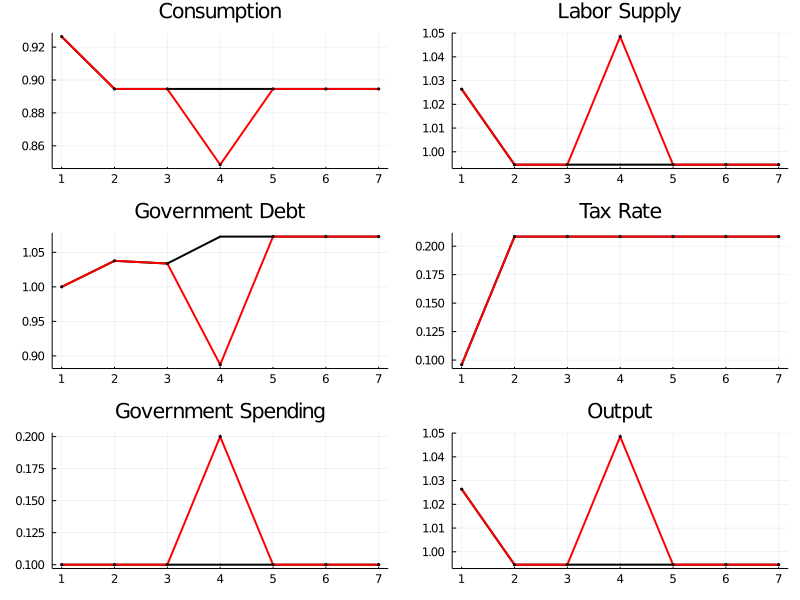

In [6]:
using Random
Random.seed!(42) # For reproducible results.

M_time_example = crra_utility(G=[0.1, 0.1, 0.1, 0.2, 0.1, 0.1],
                              Θ=ones(6))            # Θ can in principle be random

M_time_example.Π = [0.0 1.0 0.0 0.0 0.0 0.0;
                    0.0 0.0 1.0 0.0 0.0 0.0;
                    0.0 0.0 0.0 0.5 0.5 0.0;
                    0.0 0.0 0.0 0.0 0.0 1.0;
                    0.0 0.0 0.0 0.0 0.0 1.0;
                    0.0 0.0 0.0 0.0 0.0 1.0]

PP_seq_time = SequentialAllocation(M_time_example)  # Solve sequential problem

sHist_h = [1, 2, 3, 4, 6, 6, 6]
sHist_l = [1, 2, 3, 5, 6, 6, 6]

sim_seq_h = simulate(PP_seq_time, 1.0, 1, 7, sHist_h)
sim_seq_l = simulate(PP_seq_time, 1.0, 1, 7, sHist_l)

using Plots
gr(fmt=:png);
titles = hcat("Consumption",
              "Labor Supply",
              "Government Debt",
              "Tax Rate",
              "Government Spending",
              "Output")

sim_seq_l_plot = [sim_seq_l[1:4]..., M_time_example.G[sHist_l],
                  M_time_example.Θ[sHist_l].*sim_seq_l[2]]
sim_seq_h_plot = [sim_seq_h[1:4]..., M_time_example.G[sHist_h],
                  M_time_example.Θ[sHist_h].*sim_seq_h[2]]

plots = plot(layout=(3,2), size=(800,600))
for i = 1:6
    plot!(plots[i], sim_seq_l_plot[i], color=:black, lw=2,
          marker=:circle, markersize=2, label="")
    plot!(plots[i], sim_seq_h_plot[i], color=:red, lw=2,
          marker=:circle, markersize=2, label="")
    plot!(plots[i], title=titles[i], grid=true)
end
plot(plots)

**Tax smoothing**

- the tax rate is constant for all  $ t\geq 1 $  
  
  - For $ t \geq 1, t \neq 3 $, this is a consequence of $ g_t $
    being the same at all those dates  
  - For $ t = 3 $, it is a consequence of the special one-period utility
    function that we have assumed  
  - Under  other one-period utility functions, the time $ t=3 $ tax rate
    could be either higher or lower than for dates $ t \geq 1, t \neq 3 $  
  
- the tax rate is the same at $ t=3 $ for both the high $ g_t $ outcome and the low $ g_t $ outcome  


We have assumed that at $ t=0 $, the government owes positive debt $ b_0 $.

It sets the time $ t=0 $ tax rate partly with an eye to reducing the value $ u_{c,0} b_0 $ of $ b_0 $.

It does this by increasing consumption at time $ t=0 $ relative to
consumption in later periods.

This has the consequence of *raising* the time $ t=0 $ value of the  gross
interest  rate for risk-free loans between periods $ t $ and $ t+1 $, which  equals

$$
R_t = \frac{u_{c,t}}{\beta\mathbb E_{t}[u_{c,t+1}]}
$$

A tax policy that makes  time $ t=0 $ consumption be  higher than time $ t=1 $ consumption evidently increases the
risk-free rate one-period interest rate, $ R_t $, at $ t=0 $.

Raising the time $ t=0 $ risk-free interest rate makes time $ t=0 $
consumption goods cheaper relative to consumption goods at later dates, thereby
lowering the value $ u_{c,0} b_0 $ of initial government debt $ b_0 $.

We see this in a figure below that plots the time path for the risk free interest
rate under both realizations of the time $ t=3 $ government expenditure shock.

The following plot illustrates how the government lowers the interest rate at
time 0 by raising consumption

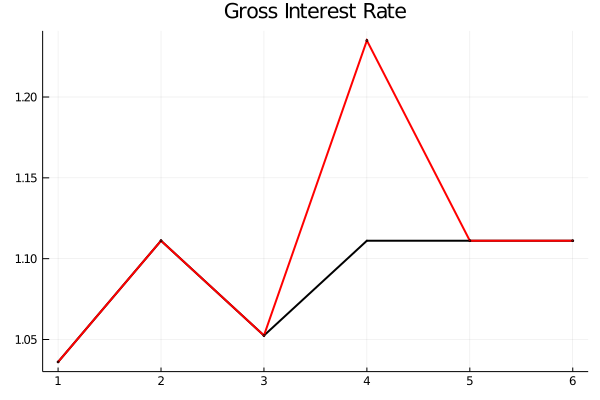

In [7]:
plot(sim_seq_l[end], color=:black, lw=2,
        marker=:circle, markersize=2, label="")
plot!(sim_seq_h[end], color=:red, lw=2,
        marker=:circle, markersize=2, label="")
plot!(title="Gross Interest Rate", grid=true)

### Government Saving

At time  $ t=0 $ the government evidently *dissaves* since $ b_1> b_0 $.

> - This is a consequence of it setting a *lower* tax rate at $ t=0 $,
  implying more consumption at $ t=0 $.  



At time $ t=1 $, the government evidently *saves* since it has set the tax
rate sufficiently high to allow it to set $ b_2 < b_1 $.

> - Its motive for doing this is that it anticipates a likely war at $ t=3 $.  



At time $ t=2 $ the government trades state-contingent Arrow securities
to hedge against  war at $ t=3 $.

> - It purchases a security that pays off when $ g_3 = g_h $.  
- It sells a security that  pays off when $ g_3 = g_l $.  
- These purchases are designed in such a way that regardless of whether or
  not there is a war at $ t=3 $, the government will begin  period
  $ t=4 $ with the *same* government debt.  
- The time $ t=4 $ debt level can be serviced with revenues from the
  constant tax rate set at times $ t\geq 1 $.  



At times $ t \geq 4 $ the government rolls over its debt, knowing that the
tax rate is set at level required to service the interest payments
on the debt and government expenditures.

### Time 0 Manipulation of Interest Rate

We have seen that when $ b_0>0 $, the Ramsey plan sets the time $ t=0 $
tax rate partly with an eye toward raising a risk-free interest
rate for one-period loans between times $ t=0 $ and $ t=1 $.

By raising this interest rate, the plan makes time $ t=0 $ goods cheap
relative to consumption goods at later times.

By doing this, it lowers the value of time $ t=0 $ debt that it has inherited
and must finance.

### Time 0  and Time-Inconsistency

In the  preceding  example,  the Ramsey tax rate at time 0 differs from its value  at time 1.

To explore what is going on here, let’s simplify things by removing  the possibility of war at time $ t=3 $.

The Ramsey problem then includes no randomness because  $ g_t = g_l $ for all $ t $.

The figure below plots the Ramsey tax rates and gross interest rates at time
$ t=0 $ and time $ t\geq1 $ as functions of the initial government debt
(using the sequential allocation solution and a CRRA utility function defined
above)

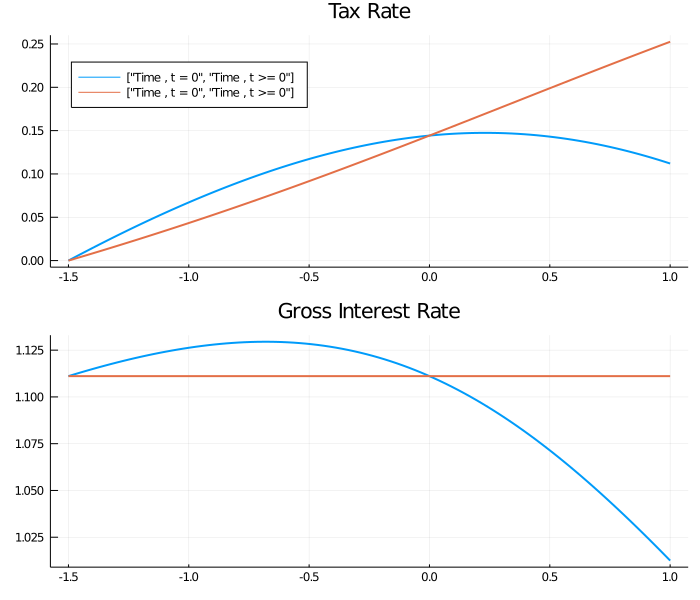

In [8]:
M2 = crra_utility(G=[0.15], Π=ones(1, 1), Θ=[1.0])

PP_seq_time0 = SequentialAllocation(M2) # solve sequential problem

B_vec = range(-1.5, 1.0, length = 100)
taxpolicy = Matrix(hcat([simulate(PP_seq_time0, B_, 1, 2)[4] for B_ in B_vec]...)')
interest_rate = Matrix(hcat([simulate(PP_seq_time0, B_, 1, 3)[end] for B_ in B_vec]...)')

titles = ["Tax Rate" "Gross Interest Rate"]
labels = [["Time , t = 0", "Time , t >= 0"], ""]
plots = plot(layout=(2,1), size =(700,600))
for (i, series) in enumerate((taxpolicy, interest_rate))
    plot!(plots[i], B_vec, series, linewidth=2, label=labels[i])
    plot!(plots[i], title=titles[i], grid=true, legend=:topleft)
end
plot(plots)

The figure indicates  that if the government enters with  positive debt, it sets
a tax rate at $ t=0 $ that is less than all later tax rates.

By setting  a lower tax rate at $ t = 0 $, the government raises consumption,
which reduces the *value* $ u_{c,0} b_0 $ of its  initial debt.

It does this by increasing $ c_0 $ and thereby lowering $ u_{c,0} $.

Conversely, if  $ b_{0} < 0 $, the Ramsey planner sets the tax rate at $ t=0 $
higher than in  subsequent periods.

A side effect of lowering time $ t=0 $ consumption  is that it raises  the
one-period  interest rate at time 0 above that of subsequent periods.

There are only two values of initial government debt at which  the tax rate is
constant for all $ t \geq 0 $.

The first is $ b_{0} = 0 $

> - Here the government can’t use the $ t=0 $ tax rate  to alter  the
  value of the initial debt.  



The second occurs when the government enters with sufficiently large  assets
that the Ramsey planner can achieve first best and sets $ \tau_t = 0 $
for all $ t $.

It is only for these two values of initial government debt that the Ramsey
plan is time-consistent.

Another way of saying this is that, except for these two values of initial
government debt, a continuation of a Ramsey plan is not a Ramsey plan.

To illustrate this, consider a Ramsey planner who starts with an initial
government debt  $ b_1 $ associated with one of the Ramsey plans computed above.

Call $ \tau_1^R $ the time $ t=0 $ tax rate chosen by the Ramsey planner
confronting this value for initial government debt government.

The figure below shows both  the tax rate  at time 1 chosen by our original
Ramsey planner and what a new Ramsey planner would choose for its
time $ t=0 $ tax rate

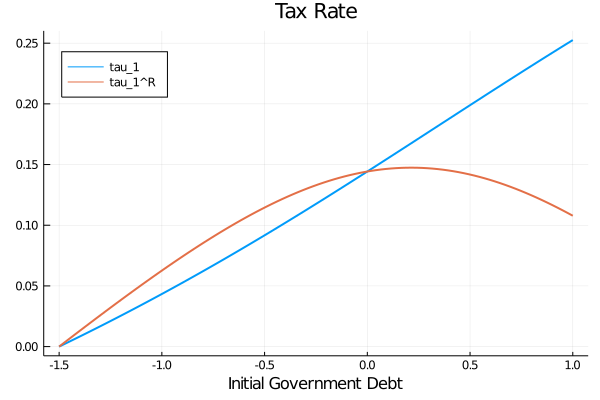

In [9]:
# Compute the debt entered with at time 1
B1_vec = hcat([simulate(PP_seq_time0, B_, 1, 2)[3][2] for B_ in B_vec]...)'

# Compute the optimal policy if the government could reset
tau1_reset = Matrix(hcat([simulate(PP_seq_time0, B1, 1, 1)[4] for B1 in B1_vec]...)')

plot(B_vec, taxpolicy[:, 2], linewidth=2, label="tau_1")
plot!(B_vec, tau1_reset, linewidth=2, label="tau_1^R")
plot!(title="Tax Rate", xlabel="Initial Government Debt", legend=:topleft, grid=true)

The tax rates in the figure are equal  for only two values of initial government debt.

### Tax Smoothing and non-CRRA Preferences

The complete tax smoothing for $ t \geq 1 $ in the preceding example is a
consequence of our having assumed CRRA preferences.

To see what is driving this outcome, we begin by noting that the Ramsey tax rate for $ t\geq 1 $ is
a time invariant function $ \tau(\Phi,g) $ of the Lagrange multiplier on
the implementability constraint and government expenditures.

For CRRA preferences, we can exploit the relations $ U_{cc}c = -\sigma U_c $
and $ U_{nn} n = \gamma U_n $ to derive

$$
\frac{(1+(1-\sigma)\Phi)U_c}{(1+(1-\gamma)\Phi)U_n} = 1
$$

from the first-order conditions.

This equation immediately implies that the tax rate is constant.

For other  preferences, the tax rate may not be constant.

For example, let the period utility function be

$$
u(c,n) = \log(c) + 0.69 \log(1-n)
$$

We will write a new constructor LogUtility to represent this utility function

In [10]:
function log_utility(;β = 0.9,
                      ψ = 0.69,
                      Π = 0.5 * ones(2, 2),
                      G = [0.1, 0.2],
                      Θ = ones(2),
                      transfers = false)
    # Derivatives of utility function
    U(c,n) = log(c) + ψ * log(1 - n)
    Uc(c,n) = 1 ./ c
    Ucc(c,n) = -c.^(-2.0)
    Un(c,n) = -ψ ./ (1.0 .- n)
    Unn(c,n) = -ψ ./ (1.0 .- n).^2.0
    n_less_than_one = true
    return Model(β, Π, G, Θ, transfers,
                U, Uc, Ucc, Un, Unn, n_less_than_one)
end

log_utility (generic function with 1 method)

Also suppose that $ g_t $ follows a two state i.i.d. process with equal
probabilities attached to $ g_l $ and $ g_h $.

To compute the tax rate, we will use both the sequential and recursive approaches described above.

The figure below plots a sample path of the Ramsey tax rate

diff = 0.00035046115353791957 
diff = 0.0001576390638812385 


diff = 7.124347949966054e-5 
diff = 3.235711433961759e-5 


diff = 1.4829596921926611e-5 
diff = 6.910518331868674e-6 


diff = 3.323186088229887e-6 
diff = 1.686978448720302e-6 


diff = 9.581801282295577e-7 


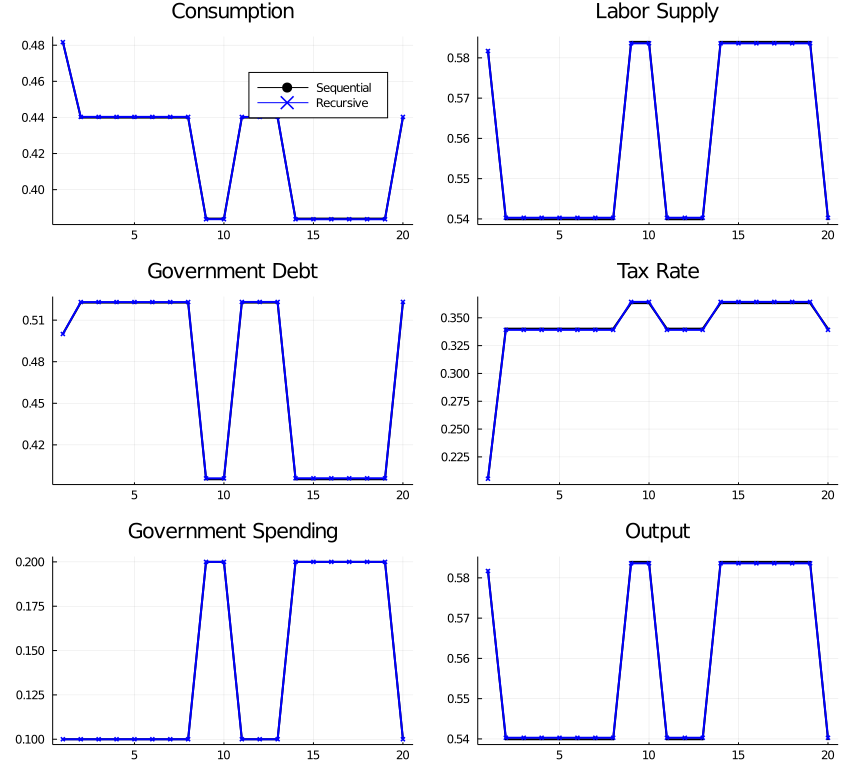

In [11]:
M1 = log_utility()
μ_grid = range(-0.6,  0.0, length = 200)
PP_seq = SequentialAllocation(M1)         # Solve sequential problem
PP_bel = RecursiveAllocation(M1, μ_grid)  # Solve recursive problem

T = 20
sHist = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1]

# Simulate
sim_seq = simulate(PP_seq, 0.5, 1, T, sHist)
sim_bel = simulate(PP_bel, 0.5, 1, T, sHist)

# Plot policies
sim_seq_plot = [sim_seq[1:4]..., M1.G[sHist], M1.Θ[sHist].*sim_seq[2]]
sim_bel_plot = [sim_bel[1:4]..., M1.G[sHist], M1.Θ[sHist].*sim_bel[2]]

titles = hcat("Consumption",
              "Labor Supply",
              "Government Debt",
              "Tax Rate",
              "Government Spending",
              "Output")
labels = [["Sequential", "Recursive"], ["",""], ["",""], ["",""], ["",""], ["",""]]
plots=plot(layout=(3,2), size=(850,780))

for i = 1:6
    plot!(plots[i], sim_seq_plot[i], color=:black, lw=2, marker=:circle,
          markersize=2, label=labels[i][1])
    plot!(plots[i], sim_bel_plot[i], color=:blue, lw=2, marker=:xcross,
          markersize=2, label=labels[i][2])
    plot!(plots[i], title=titles[i], grid=true, legend=:topright)
end
plot(plots)

As should be expected, the recursive and sequential solutions produce almost
identical allocations.

Unlike outcomes with CRRA preferences, the tax rate is not perfectly smoothed.

Instead the government raises the tax rate when $ g_t $ is high.

## Further Comments

A [related lecture](amss.html) describes an extension of the Lucas-Stokey model
by  Aiyagari, Marcet, Sargent, and Seppälä (2002) [[AMSS02]](../zreferences.html#amss2002).

In th AMSS economy, only a risk-free bond is traded.

That lecture compares the recursive representation of the Lucas-Stokey model
presented in this lecture with  one for an AMSS economy.

By comparing these recursive formulations, we shall glean a sense in which the
dimension of the state is lower in the Lucas Stokey model.

Accompanying that difference in dimension will be  different dynamics of government debt.